In [ ]:
# Codes are adapted from http://bit.ly/2U7ttYT (파이토치 첫걸음,한빛미디어)

# Data_Augmentation

- Scale
- Crop
- Flip
- Rotate (using PIL Transform )

## 1. Settings
### 1) Import required libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
cd '/content/drive/MyDrive/ColabNotebooks/Lecture/Pytorch/Codes'

/content/drive/MyDrive/ColabNotebooks/Lecture/Pytorch/Codes


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

### 2) Set hyperparameters

In [4]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 10

## 2. Data

### 1) Download Data

In [5]:
mnist_train = dset.MNIST("./data", train=True, 
                         transform = transforms.Compose([
                             transforms.Resize(34),                             # 원래 28x28인 이미지를 34x34로 늘립니다.
                             transforms.CenterCrop(28),                         # 중앙 28x28를 뽑아냅니다.
                             transforms.RandomHorizontalFlip(),                 # 랜덤하게 좌우반전 합니다.
                             transforms.Lambda(lambda x: x.rotate(90)),         # 람다함수를 이용해 90도 회전해줍니다.
                             transforms.ToTensor(),                             # 이미지를 텐서로 변형합니다.
                         ]),
                         target_transform=None,
                         download=True)


mnist_test = dset.MNIST("./data", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

### 2) Check Dataset

In [6]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
mnist_test.__getitem__(0)[0].size(), mnist_test.__len__()

torch.Size([1, 28, 28]) 60000


(torch.Size([1, 28, 28]), 10000)

### 3) Set DataLoader

In [7]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

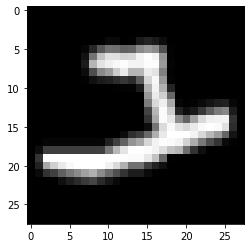

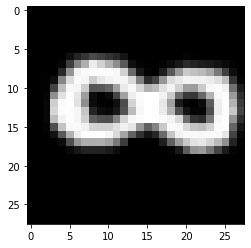

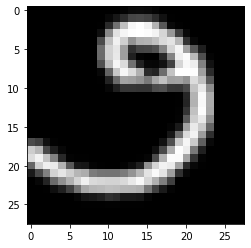

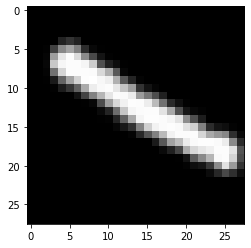

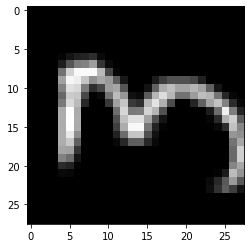

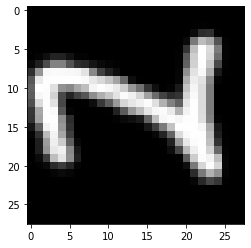

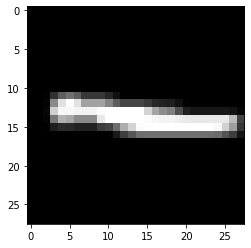

In [8]:
# 이미지를 보면 알수 있듯이 augmentation을 데이터에 맞게 하지 않으면 말도 안되는걸 학습하게 됩니다.
# 90도 돌리거나 좌우반전을 함으로써 의미를 잃어버리는 경우도 있기 때문에 데이터에 맞는 augmentation을 해야합니다.

for idx,(img,label) in enumerate(train_loader):
  plt.imshow(img[0,0,...],cmap="gray")
  plt.show()
  if idx > 5:
    break

## 3. Model & Optimizer

### 1) CNN Model

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,3,padding=1),  # 28 x 28
            nn.ReLU(),
            nn.Conv2d(16,32,3,padding=1), # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2,2),            # 14 x 14
            nn.Conv2d(32,64,3,padding=1), # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2,2)             #  7 x 7
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size,-1)
        out = self.fc_layer(out)
        return out

### 2) Loss func & Optimizer

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

cuda:0


## 4. Train 

In [11]:
for i in range(num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0:
        print(loss)          

tensor(2.3082, device='cuda:0', grad_fn=<NllLossBackward>)


In [ ]:
#param_list = list(model.parameters())
#print(param_list)

## 5. Test

In [12]:
correct = 0
total = 0

with torch.no_grad():
  for image,label in test_loader:
      x = image.to(device)
      y_= label.to(device)

      output = model.forward(x)
      _,output_index = torch.max(output,1)

      total += label.size(0)
      correct += (output_index == y_).sum().float()

  print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 6.350160121917725
